In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

# drought_ele & drought_nonele

## 不区分LA-LC

### Density paired sites prepare

In [2]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
dens=read_img(spei_path+'ele-density_001_231123.tif')[0]
print("dens:",dens.min(),dens.max())
#forest_mask[forest_mask==0]=np.nan

dens: nan nan


In [3]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

### slide window

In [4]:
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

#----------------dens不一样，因为dens和DEAA重叠，DAA没有dens，所以delta dens就是DEAA部分-------------------------
kk=slide_window_mean(25,DEAA*mask,dens)
np.save(drv_path+'Elephant-density_DEAA_density_0.25deg_240504',kk)

### dem,slope mask

In [2]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_DEAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_DAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_DEAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_DAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [3]:
res_name=['treeH','tc_planet']
delta=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_DEAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(260, 316)

In [4]:
dens=np.load(drv_path+'Elephant-density_DEAA_density_0.25deg_240504.npy',allow_pickle=True)*dd_mask
delta.append(dens)

In [5]:
np.count_nonzero(~np.isnan(delta[0]))

2742

### fit density

In [6]:
dd_name=['treeH','tc_planet','dens']
dd=np.copy(delta)
dd[~np.isnan(dd)]=1
for i in range(3):
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(dd[i])))
    
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))
for i in range(3):
    dd_mask=dd_mask*dd[i]

delta_dd=np.copy(delta)
for i in range(3):
    delta_dd[i]=delta[i]*dd_mask
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(delta_dd[i])))

treeH count is 2742
tc_planet count is 2843
dens count is 2887
treeH count is 2684
tc_planet count is 2684
dens count is 2684


In [7]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

pd_delta=[]
for i in range(3):
    pd_delta.append(kill_nan(delta_dd[i]))
#['ndvi_res','soc','clay','bulk','lst','spei','gpm','Stock_rd','Stock_wc','Fan_rd','treeH','tc','agb','Bio']
pd_delta=list(map(list, zip(*pd_delta)))#list转置
np.array(pd_delta).shape

(2684, 3)

In [8]:
df=pd.DataFrame(pd_delta,columns=['TH','TC','Ele_Dens'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2684 entries, 0 to 2683
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TH        2684 non-null   float64
 1   TC        2684 non-null   float64
 2   Ele_Dens  2684 non-null   float64
dtypes: float64(3)
memory usage: 63.0 KB


In [9]:
del_th=df['TH']
del_tc=df['TC']
std0=np.std(del_th)
std1=np.std(del_tc)
std0,std1

(3.835388112675733, 13.966974283482072)

In [10]:
ele_dens=df['Ele_Dens']

In [11]:
dens_mean=np.around(ele_dens,decimals=0)#四舍五入，建立梯度
#dens_mean[dens_mean>60]=60
print(dens_mean.min(),dens_mean.max())
dens_uni=np.unique(dens_mean)
th_val=[]
tc_val=[]
count=[]
unt=[]
weight=[]
std_th=[]
std_tc=[]
for v in dens_uni:
    v_th=[]
    v_tc=[]
    ww=[]
    c=[]
    for i in range(len(del_th)):
        if dens_mean[i]==v:
            v_th.append(del_th[i])
            v_tc.append(del_tc[i])
            #ww.append(wei_a[i])
            c.append(1)
    count.append(np.sum(c))
    th_val.append(np.average(v_th))#,weights=ww
    tc_val.append(np.average(v_tc))#,weights=ww
    std_th.append(stats.sem(v_th))
    std_tc.append(stats.sem(v_tc))
len(th_val)

0.0 105.0


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


44

In [12]:
len(dens_uni)

44

In [19]:
#剔除异常值

th_val_a=[]
dens_uni_th=[]
a_std_th=[]

for i in range(len(tc_val)):
    if th_val[i]<10:
        th_val_a.append(th_val[i])
        dens_uni_th.append(dens_uni[i])
        a_std_th.append(std_th[i])

tc_val_a=[]
dens_uni_tc=[]
a_std_tc=[]
for i in range(len(tc_val)):
    if tc_val[i]<29:
        tc_val_a.append(tc_val[i])
        dens_uni_tc.append(dens_uni[i])
        a_std_tc.append(std_tc[i])

val=[th_val_a,tc_val_a]
std=[a_std_th,a_std_tc]
dens=[dens_uni_th,dens_uni_tc]
#count=[count_th,count_tc]


### fig

In [14]:
"""
val=[th_val,tc_val]
std=[std_th,std_tc]
dens=[dens_uni,dens_uni]
count=[count,count]
"""

In [15]:
np.max(tc_val)

29.512579917907715

0.19553780807827503
0.0029881579265836396
0.14022007823472749
0.0029881579265836396


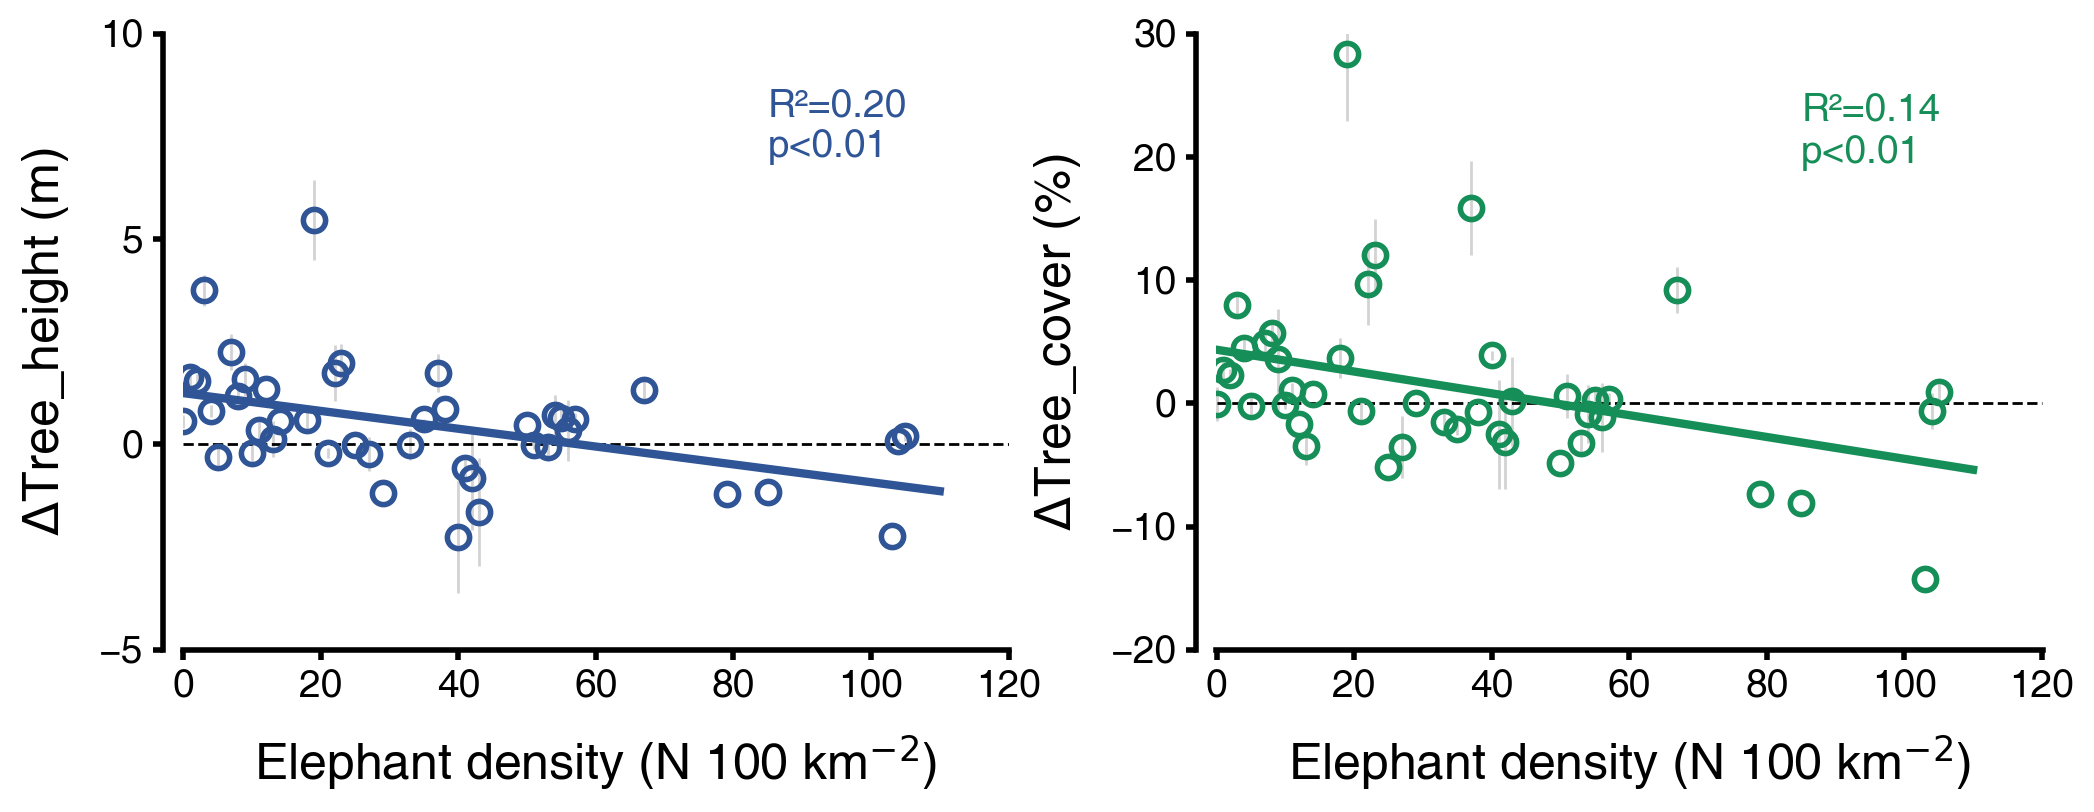

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pingouin as pg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.25,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
cl1 = [(47/255,85/255,151/255),(22/255,142/255,88/255)]

x1=np.linspace(0,110,1000)
x2=np.linspace(0,120,1000)
zero=np.zeros((1000))

for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.errorbar(dens[i],val[i],yerr=[std[i],std[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=8,mfc='none',mec=cl1[i],mew=2,capsize=0)
    plt.plot(x2,zero,color='black',linestyle='--',linewidth=1)
    #ax.vlines(30,-5,10,lw=1,ls='--',color='grey')
    plt.xlabel('Elephant density (N 100 km$^{-2}$)',fontsize=18,labelpad=10)
    ax.set_xlim(-0.1,120.1)
    ax.set_xticks(np.arange(0,120.01,20))
    ax=plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',-3))
    if i==0:
        poly=np.polyfit(dens[i],val[i],deg=1)#一元二次方程拟合,,w=count[i]
        y_value=np.polyval(poly,x1)
        plt.plot(x1,y_value,color=cl1[i],linewidth=3)
        yfit=np.polyval(poly,dens[i])
        r2=r2_score(val[i],yfit)
        slope, intercept, r_value, p_value, std_err = stats.linregress(val[0], dens[0])
        print(r2)
        print(p_value)
        ax.text(85,8, 'R\u00b2={:.2f}'.format(r2),fontsize=14,color=cl1[i])
        if p_value<0.001:
            ax.text(85,7, 'p<0.001',fontsize=14,color=cl1[i])
        elif p_value<0.01:
            ax.text(85,7, 'p<0.01',fontsize=14,color=cl1[i])
        elif p_value<0.05:
            ax.text(85,7, 'p<0.05',fontsize=14,color=cl1[i])
        else:
            ax.text(85,7, 'p={}'.format(p_value),fontsize=14,color=cl1[i])
        ax.set_ylim(-5,10)
        ax.set_yticks(np.arange(-5,10.01,5))
        ax.set_ylabel(''r'$\Delta$Tree_height'" (m)",fontsize=18,labelpad=10)
    if i==1:
        poly=np.polyfit(dens[i],val[i],deg=1)#一元二次方程拟合,,w=count[i]
        y_value=np.polyval(poly,x1)
        plt.plot(x1,y_value,color=cl1[i],linewidth=3)
        yfit=np.polyval(poly,dens[i])
        r2=r2_score(val[i],yfit)
        #print(r2)
        x=np.array(val[i])
        X = np.column_stack((x, x**2))
        lm = pg.linear_regression(X, dens[i])
        #print(lm['r2'][2])
        #print(lm['pval'][2])
        slope, intercept, r_value, p_value, std_err = stats.linregress(val[0], dens[0])
        print(r2)
        print(p_value)
        ax.text(85,23, 'R\u00b2={:.2f}'.format(r2),fontsize=14,color=cl1[i])
        if p_value<0.001:
            ax.text(85,19.5, 'p<0.001',fontsize=14,color=cl1[i])
        elif p_value<0.01:
            ax.text(85,19.5, 'p<0.01',fontsize=14,color=cl1[i])
        elif p_value<0.05:
            ax.text(85,19.5, 'p<0.05',fontsize=14,color=cl1[i])
        else:
            ax.text(85,19.5, 'p={}'.format(p_value),fontsize=14,color=cl1[i])
        ax.set_ylim(-20,30)
        ax.set_yticks(np.arange(-20,30.01,10))
        ax.set_ylabel(''r'$\Delta$Tree_cover'" (%)",fontsize=18,labelpad=10)
    
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig4.tif", dpi=600, bbox_inches = 'tight')

In [40]:
import pingouin as pg
x=np.array(val[0])
X = np.column_stack((x, x**2))
lm = pg.linear_regression(X, dens[0])
lm.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,30.185,3.168,9.528,0.000,0.168,0.121,23.760,36.609
1,x1,-6.103,2.668,-2.287,0.028,0.168,0.121,-11.513,-0.692
2,x2,0.340,0.252,1.347,0.187,0.168,0.121,-0.172,0.851


In [41]:
lm = pg.linear_regression(val[1], dens[1])
lm.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,28.493,3.140,9.074,0.00,0.086,0.061,22.131,34.855
1,x1,-0.735,0.394,-1.867,0.07,0.086,0.061,-1.533,0.063


In [42]:
x=np.array(val[1])
X = np.column_stack((x, x**2))
lm = pg.linear_regression(X, dens[1])
lm.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,28.339,3.119,9.087,0.000,0.124,0.076,22.014,34.664
1,x1,-1.759,0.907,-1.939,0.060,0.124,0.076,-3.599,0.081
2,x2,0.046,0.037,1.251,0.219,0.124,0.076,-0.028,0.120


In [46]:
import statsmodels.api as sm
from scipy import stats

x=np.array(val[1])
X=np.column_stack((x,x**2))
X=sm.add_constant(X)
est = sm.OLS(dens[1], X)
print(est.fit().f_pvalue)

0.091957394669517


In [249]:
est.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     8.222
Date:                Wed, 27 Mar 2024   Prob (F-statistic):            0.00231
Time:                        21:14:58   Log-Likelihood:                -103.32
No. Observations:                  24   AIC:                             212.6
Df Residuals:                      21   BIC:                             216.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5996      4.603      2.737      0.012       3.028      22.172
x1            -2.3390      0.752     -3.111      0.005      -3.902      -0.776
x2             0.2871      0.080      3.584      0.002       0.120       0.454
==============================================================================
Omnibus:                       29.573   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.423
Skew:                           2.318   Prob(JB):                     4.59e-14
Kurtosis:                       9.319   Cond. No.                         72.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [258]:
x=np.array(val[0])
x=sm.add_constant(x)
est = sm.OLS(dens[0], x)
print(est.fit().f_pvalue)

0.05676410674390009


In [259]:
est.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     4.065
Date:                Wed, 27 Mar 2024   Prob (F-statistic):             0.0568
Time:                        21:16:45   Log-Likelihood:                -104.11
No. Observations:                  23   AIC:                             212.2
Df Residuals:                      21   BIC:                             214.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.8467      5.350      4.645      0.000      13.721      35.972
x1            -9.4907      4.707     -2.016      0.057     -19.280       0.299
==============================================================================
Omnibus:                       25.104   Durbin-Watson:                   0.456
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.971
Skew:                           2.126   Prob(JB):                     2.09e-09
Kurtosis:                       7.861   Cond. No.                         1.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 区分LA-LC

In [ ]:
"""
原始方案，按ele-density整数梯度统计
区分LA-LC
"""

In [30]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_DEAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_DAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_DEAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_DAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [31]:
#统计过程见py_v4_01_forest-structure_240501，section 3
dist_name=['treeH','tc_planet']
delta_LA=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_LA_da_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_DAA_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta_LA.append(ff)
    
delta_LC=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_LC_da_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_DAA_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta_LC.append(ff)
delta_LC[0].shape

(260, 316)

In [32]:
for i in range(2):
    print(dist_name[i],"TH count is",np.count_nonzero(~np.isnan(delta_LA[i])))
for i in range(2):
    print(dist_name[i],"TC count is",np.count_nonzero(~np.isnan(delta_LC[i])))

treeH TH count is 1584
tc_planet TH count is 1698
treeH TC count is 1123
tc_planet TC count is 1124


In [33]:
dens=np.load(drv_path+'Elephant-density_DEAA_density_0.25deg_240504.npy',allow_pickle=True)*dd_mask
delta_LA.append(dens)
delta_LC.append(dens)

In [34]:
dd=np.copy(delta_LA)
dd[~np.isnan(dd)]=1
for i in range(3):
    print(np.count_nonzero(~np.isnan(dd[i])))
    
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))
for i in range(3):
    dd_mask=dd_mask*dd[i]

delta_dd_LA=np.copy(delta_LA)
for i in range(3):
    delta_dd_LA[i]=delta_LA[i]*dd_mask
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(delta_dd_LA[i])))

1584
1698
2887
treeH count is 1551
tc_planet count is 1551
dens count is 1551


In [35]:
dd=np.copy(delta_LC)
dd[~np.isnan(dd)]=1
for i in range(3):
    print(np.count_nonzero(~np.isnan(dd[i])))
    
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))
for i in range(3):
    dd_mask=dd_mask*dd[i]

delta_dd_LC=np.copy(delta_LC)
for i in range(3):
    delta_dd_LC[i]=delta_LC[i]*dd_mask
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(delta_dd_LC[i])))

1123
1124
2887
treeH count is 1095
tc_planet count is 1095
dens count is 1095


In [36]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

pd_delta=[]
for i in range(3):
    pd_delta.append(kill_nan(delta_dd[i]))
#['ndvi_res','soc','clay','bulk','lst','spei','gpm','Stock_rd','Stock_wc','Fan_rd','treeH','tc','agb','Bio']
pd_delta=list(map(list, zip(*pd_delta)))#list转置
np.array(pd_delta).shape

(2684, 3)

In [37]:
LA_th=kill_nan(delta_dd_LA[0])
LA_tc=kill_nan(delta_dd_LA[1])
LA_dens=kill_nan(delta_dd_LA[2])
LC_th=kill_nan(delta_dd_LC[0])
LC_tc=kill_nan(delta_dd_LC[1])
LC_dens=kill_nan(delta_dd_LC[2])

In [38]:
len(LA_th),len(LC_th),len(LA_tc),len(LC_tc)

(1551, 1095, 1551, 1095)

In [39]:
dens_mean_LA=np.around(LA_dens,decimals=0)#四舍五入，建立梯度
print(dens_mean_LA.min(),dens_mean_LA.max())
dens_uni_LA=np.unique(dens_mean_LA)
th_val_LA=[]
tc_val_LA=[]
count_LA=[]
std_th_LA=[]
std_tc_LA=[]
for v in dens_uni_LA:
    v_th=[]
    v_tc=[]
    ww=[]
    c=[]
    for i in range(len(LA_th)):
        if dens_mean_LA[i]==v:
            v_th.append(LA_th[i])
            v_tc.append(LA_tc[i])
            #ww.append(wei_a[i])
            c.append(1)
    count_LA.append(np.sum(c))
    th_val_LA.append(np.average(v_th))#,weights=ww
    tc_val_LA.append(np.average(v_tc))#,weights=ww
    std_th_LA.append(stats.sem(v_th))
    std_tc_LA.append(stats.sem(v_tc))
len(th_val_LA)

1.0 105.0


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


29

In [40]:
dens_mean_LC=np.around(LC_dens,decimals=0)#四舍五入，建立梯度
print(dens_mean_LC.min(),dens_mean_LC.max())
dens_uni_LC=np.unique(dens_mean_LC)
th_val_LC=[]
tc_val_LC=[]
count_LC=[]
std_th_LC=[]
std_tc_LC=[]
for v in dens_uni_LC:
    v_th=[]
    v_tc=[]
    ww=[]
    c=[]
    for i in range(len(LC_th)):
        if dens_mean_LC[i]==v:
            v_th.append(LC_th[i])
            v_tc.append(LC_tc[i])
            #ww.append(wei_a[i])
            c.append(1)
    count_LC.append(np.sum(c))
    th_val_LC.append(np.average(v_th))#,weights=ww
    tc_val_LC.append(np.average(v_tc))#,weights=ww
    std_th_LC.append(stats.sem(v_th))
    std_tc_LC.append(stats.sem(v_tc))
len(th_val_LC)

0.0 57.0


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


30

In [41]:
dens_uni_LC

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 18., 19., 27., 33., 35., 38., 40., 41., 42., 43., 51., 53.,
       54., 55., 56., 57.])

In [42]:
dens_uni_LA

array([  1.,   2.,   3.,   4.,   5.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  18.,  19.,  21.,  22.,  23.,  25.,  27.,  29.,  37.,  42.,
        50.,  67.,  79.,  85., 103., 104., 105.])

### fig

C:\Users\dess\AppData\Local\Temp\ipykernel_21216\1463192144.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(dens_uni_LC,val_LC[i],yerr=[std_LC[i],std_LC[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=6,mfc='none',mec=cl2,capsize=2,marker='x')
C:\Users\dess\AppData\Local\Temp\ipykernel_21216\1463192144.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(dens_uni_LC,val_LC[i],yerr=[std_LC[i],std_LC[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=6,mfc='none',mec=cl2,capsize=2,marker='x')


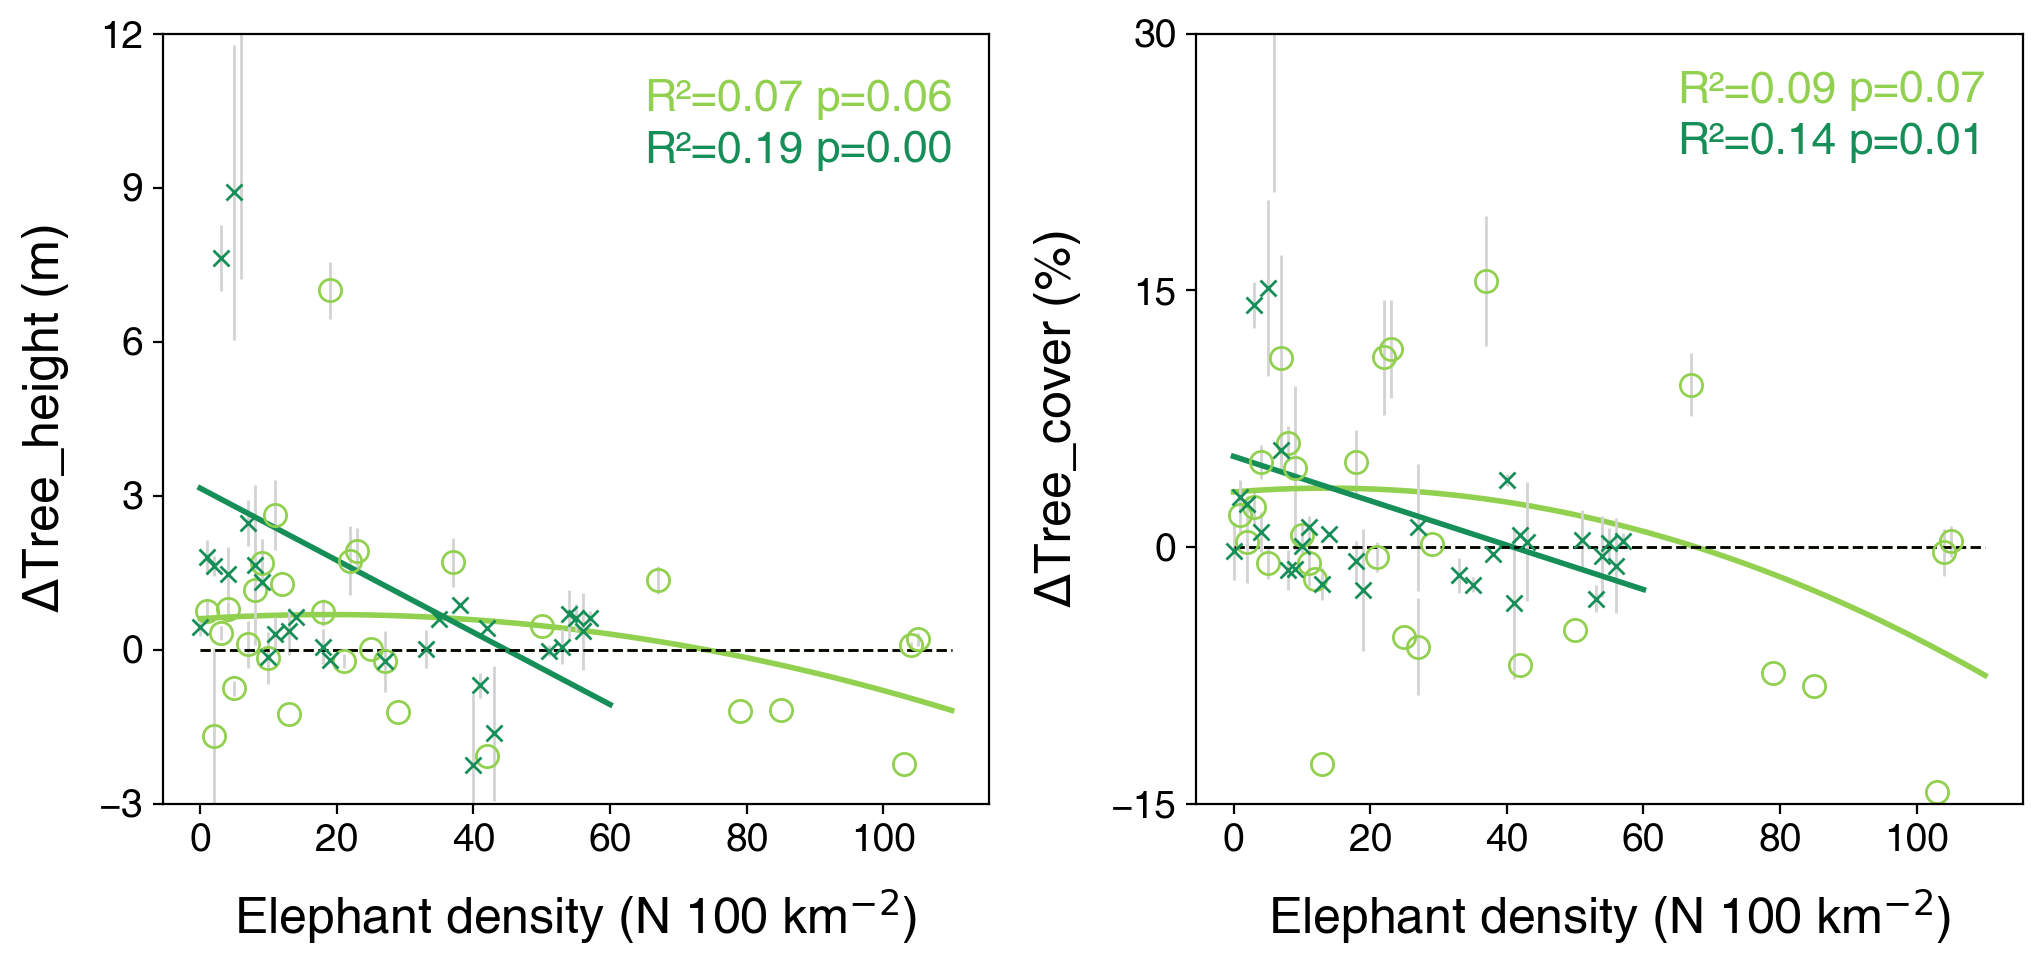

In [44]:
val_LA=[th_val_LA,tc_val_LA]
std_LA=[std_th_LA,std_tc_LA]

val_LC=[th_val_LC,tc_val_LC]
std_LC=[std_th_LC,std_tc_LC]

from sklearn.metrics import r2_score
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,5)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.25,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs

x1=np.linspace(0,110,1000)
x2=np.linspace(0,60,1000)
zero=np.zeros((1000))

cl1 = np.array([(146,208,80)])
cl=cl1/255

cl2 = np.array([(22,142,88)])
cl2=cl2/255

for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    #---------------LA---------------
    ax.errorbar(dens_uni_LA,val_LA[i],yerr=[std_LA[i],std_LA[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=8,mfc='none',mec=cl,capsize=2)
    if i ==0:
        poly=np.polyfit(dens_uni_LA,val_LA[i],deg=2)#一元二次方程拟合,,w=count
    elif i==1:
        poly=np.polyfit(dens_uni_LA,val_LA[i],deg=2)#一元二次方程拟合,,w=count
    y_value=np.polyval(poly,x1)
    yfit=np.polyval(poly,dens_uni_LA)
    r2=r2_score(val_LA[i],yfit)
    lm = pg.linear_regression(dens_uni_LA,val_LA[i])
    r2=lm['r2'][0]
    p_value=lm['pval'][0]
    plt.plot(x1,y_value,color=cl,linewidth=2)
    plt.plot(x1,zero,color=cl,linestyle='--',linewidth=1)
    #---------------LC---------------
    ax.errorbar(dens_uni_LC,val_LC[i],yerr=[std_LC[i],std_LC[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=6,mfc='none',mec=cl2,capsize=2,marker='x')
    poly=np.polyfit(dens_uni_LC,val_LC[i],deg=1)#一元二次方程拟合,,w=count
    y_value=np.polyval(poly,x2)
    yfit=np.polyval(poly,dens_uni_LC)
    #slope, intercept, r_value, p_value1, std_err = stats.linregress(dens_uni_LC,val_LC[i])
    lm = pg.linear_regression(dens_uni_LC,val_LC[i])
    r2_a=lm['r2'][0]
    p_value1=lm['pval'][0]
    plt.plot(x2,y_value,color=cl2,linewidth=2)
    #plt.plot(x2,zero,color='black',linestyle='--',linewidth=1)
    ax.hlines(0,0,110,lw=1,ls='--',color='black')
    plt.xlabel('Elephant density (N 100 km$^{-2}$)',fontsize=18,labelpad=10)
    #ax.set_xlim(0,110)
    #ax.set_xticks(np.arange(0,110.01,20))
    if i==0:
        ax.text(65,10.5, 'R\u00b2={:.2f}'.format(r2),color=(146/255,208/255,80/255))
        ax.text(65,9.5, 'R\u00b2={:.2f}'.format(r2_a),color=(22/255,142/255,88/255))
        ax.text(90,10.5, 'p={:.2f}'.format(p_value),color=(146/255,208/255,80/255))
        ax.text(90,9.5, 'p={:.2f}'.format(p_value1),color=(22/255,142/255,88/255))
        ax.set_ylim(-3,12)
        ax.set_yticks(np.arange(-3,12.01,3))
        ax.set_ylabel(''r'$\Delta$Tree_height'" (m)",fontsize=18,labelpad=10)
    if i==1:
        ax.text(65,26, 'R\u00b2={:.2f}'.format(r2),color=(146/255,208/255,80/255))
        ax.text(65,23, 'R\u00b2={:.2f}'.format(r2_a),color=(22/255,142/255,88/255))
        ax.text(90,26, 'p={:.2f}'.format(p_value),color=(146/255,208/255,80/255))
        ax.text(90,23, 'p={:.2f}'.format(p_value1),color=(22/255,142/255,88/255))
        ax.set_ylim(-15,30)
        ax.set_yticks(np.arange(-15,30.01,15))
        ax.set_ylabel(''r'$\Delta$Tree_cover'" (%)",fontsize=18,labelpad=10)
        
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(labelsize=14)



In [63]:
lm = pg.linear_regression(dens_uni_LC,val_LC[0])
lm.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3.158,0.998,3.164,0.010,0.113,0.024,0.934,5.381
1,x1,-0.070,0.062,-1.127,0.286,0.113,0.024,-0.207,0.068


# Ele & non_ele

## 不区分LA-LC

In [3]:
#有象区&无象区
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>0]=1
dt=np.ones((6500,7900))
non_ele=dt-ele
ele=ele.astype(np.float32)
ele[ele==0]=np.nan
non_ele=non_ele.astype(np.float32)
non_ele[non_ele==0]=np.nan

In [7]:
dens=read_img(spei_path+'ele-density_001_231123.tif')[0]
print("dens:",dens.min(),dens.max())

dens: nan nan


In [5]:
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [8]:
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

#----------------dens不一样，因为dens和DEAA重叠，DAA没有dens，所以delta dens就是DEAA部分-------------------------
kk=slide_window_mean(25,ele*mask,dens)
np.save(drv_path+'Elephant-density_ele_area_density_0.25deg_240504',kk)

In [28]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(drv_path+'Forest-structure_ele_area_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_nonele_area_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_ele_area_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_nonele_area_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [29]:
res_name=['treeH','tc_planet']
delta=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_ele_area_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(drv_path+'Forest-structure_nonele_area_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=f1-f2
    delta.append(ff)
delta[0].shape

(260, 316)

In [30]:
dens=np.load(drv_path+'Elephant-density_ele_area_density_0.25deg_240504.npy',allow_pickle=True)*dd_mask
delta.append(dens)

In [31]:
np.count_nonzero(~np.isnan(delta[0]))

6039

### fig density

In [87]:
dd_name=['treeH','tc_planet','dens']
dd=np.copy(delta)
dd[~np.isnan(dd)]=1
for i in range(3):
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(dd[i])))
    
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))
for i in range(3):
    dd_mask=dd_mask*dd[i]

delta_dd=np.copy(delta)
for i in range(3):
    delta_dd[i]=delta[i]*dd_mask
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(delta_dd[i])))

treeH count is 6039
tc_planet count is 6650
dens count is 6789
treeH count is 5802
tc_planet count is 5802
dens count is 5802


In [88]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

pd_delta=[]
for i in range(3):
    pd_delta.append(kill_nan(delta_dd[i]))
#['ndvi_res','soc','clay','bulk','lst','spei','gpm','Stock_rd','Stock_wc','Fan_rd','treeH','tc','agb','Bio']
pd_delta=list(map(list, zip(*pd_delta)))#list转置
np.array(pd_delta).shape

(5802, 3)

In [89]:
df=pd.DataFrame(pd_delta,columns=['TH','TC','Ele_Dens'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TH        5802 non-null   float64
 1   TC        5802 non-null   float64
 2   Ele_Dens  5802 non-null   float64
dtypes: float64(3)
memory usage: 136.1 KB


In [90]:
del_th=df['TH']
del_tc=df['TC']
std0=np.std(del_th)
std1=np.std(del_tc)
std0,std1

(3.6575045478577386, 15.12126313317472)

In [91]:
ele_dens=df['Ele_Dens']

In [92]:
dens_mean=np.around(ele_dens,decimals=0)#四舍五入，建立梯度
#dens_mean[dens_mean>60]=60
print(dens_mean.min(),dens_mean.max())
dens_uni=np.unique(dens_mean)
th_val=[]
tc_val=[]
count=[]
unt=[]
weight=[]
std_th=[]
std_tc=[]
for v in dens_uni:
    v_th=[]
    v_tc=[]
    ww=[]
    c=[]
    for i in range(len(del_th)):
        if dens_mean[i]==v:
            v_th.append(del_th[i])
            v_tc.append(del_tc[i])
            #ww.append(wei_a[i])
            c.append(1)
    count.append(np.sum(c))
    th_val.append(np.average(v_th))#,weights=ww
    tc_val.append(np.average(v_tc))#,weights=ww
    std_th.append(stats.sem(v_th))
    std_tc.append(stats.sem(v_tc))
len(th_val)

0.0 105.0


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


63

In [40]:
#剔除异常值
"""
th_val_a=[]
dens_uni_th=[]
a_std_th=[]

for i in range(len(tc_val)):
    if th_val[i]<10:
        th_val_a.append(th_val[i])
        dens_uni_th.append(dens_uni[i])
        a_std_th.append(std_th[i])
"""
tc_val_a=[]
dens_uni_tc=[]
a_std_tc=[]
for i in range(len(tc_val)):
    if tc_val[i]>-15:
        tc_val_a.append(tc_val[i])
        dens_uni_tc.append(dens_uni[i])
        a_std_tc.append(std_tc[i])

val=[th_val,tc_val_a]
std=[std_th,a_std_tc]
dens=[dens_uni,dens_uni_tc]
#count=[count_th,count_tc]


### fig

In [93]:
val=[th_val,tc_val]
std=[std_th,std_tc]
dens=[dens_uni,dens_uni]
count=[count,count]

0.24043998085599116
4.5135996612942245e-05
0.08075601801716459
0.023997771465220932


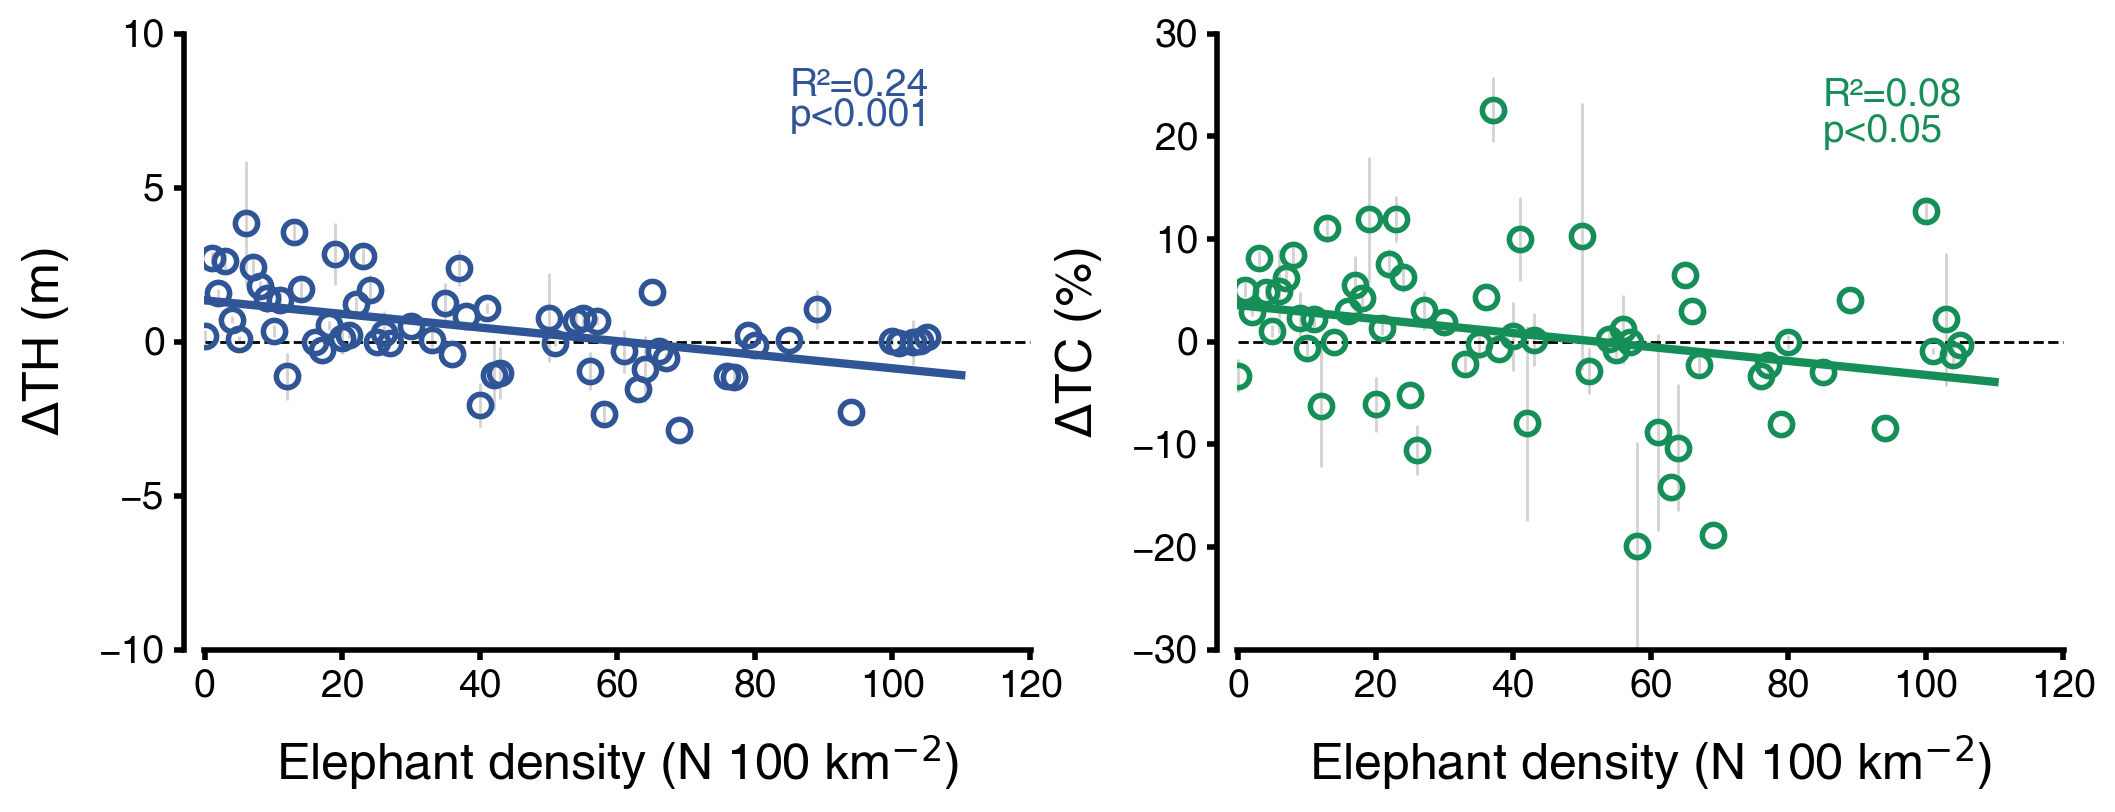

In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pingouin as pg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.25,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs
cl1 = [(47/255,85/255,151/255),(22/255,142/255,88/255)]

x1=np.linspace(0,110,1000)
x2=np.linspace(0,120,1000)
zero=np.zeros((1000))

for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.errorbar(dens[i],val[i],yerr=[std[i],std[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=8,mfc='none',mec=cl1[i],mew=2,capsize=0)
    plt.plot(x2,zero,color='black',linestyle='--',linewidth=1)
    #ax.vlines(30,-5,10,lw=1,ls='--',color='grey')
    plt.xlabel('Elephant density (N 100 km$^{-2}$)',fontsize=18,labelpad=10)
    ax.set_xlim(-0.1,120.1)
    ax.set_xticks(np.arange(0,120.01,20))
    ax=plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',-3))
    if i==0:
        poly=np.polyfit(dens[i],val[i],deg=1)#一元二次方程拟合,,w=count[i]
        y_value=np.polyval(poly,x1)
        plt.plot(x1,y_value,color=cl1[i],linewidth=3)
        yfit=np.polyval(poly,dens[i])
        r2=r2_score(val[i],yfit)
        slope, intercept, r_value, p_value, std_err = stats.linregress(val[0], dens[0])
        print(r2)
        print(p_value)
        ax.text(85,8, 'R\u00b2={:.2f}'.format(r2),fontsize=14,color=cl1[i])
        if p_value<0.001:
            ax.text(85,7, 'p<0.001',fontsize=14,color=cl1[i])
        elif p_value<0.01:
            ax.text(85,7, 'p<0.01',fontsize=14,color=cl1[i])
        elif p_value<0.05:
            ax.text(85,7, 'p<0.05',fontsize=14,color=cl1[i])
        else:
            ax.text(85,7, 'p={}'.format(p_value),fontsize=14,color=cl1[i])
        ax.set_ylim(-10,10)
        ax.set_yticks(np.arange(-10,10.01,5))
        ax.set_ylabel(''r'$\Delta$TH'" (m)",fontsize=18,labelpad=10)
    if i==1:
        poly=np.polyfit(dens[i],val[i],deg=1)#一元二次方程拟合,,w=count[i]
        y_value=np.polyval(poly,x1)
        plt.plot(x1,y_value,color=cl1[i],linewidth=3)
        yfit=np.polyval(poly,dens[i])
        r2=r2_score(val[i],yfit)
        print(r2)
        x=np.array(val[i])
        X = np.column_stack((x, x**2))
        lm = pg.linear_regression(X, dens[i])
        #r2=lm['r2'][2]
        #p_value=lm['pval'][2]
        slope, intercept, r_value, p_value, std_err = stats.linregress(val[i], dens[i])
        #print(r2)
        print(p_value)
        ax.text(85,23, 'R\u00b2={:.2f}'.format(r2),fontsize=14,color=cl1[i])
        if p_value<0.001:
            ax.text(85,19.5, 'p<0.001',fontsize=14,color=cl1[i])
        elif p_value<0.01:
            ax.text(85,19.5, 'p<0.01',fontsize=14,color=cl1[i])
        elif p_value<0.05:
            ax.text(85,19.5, 'p<0.05',fontsize=14,color=cl1[i])
        else:
            ax.text(85,19.5, 'p={}'.format(p_value),fontsize=14,color=cl1[i])
        ax.set_ylim(-30,30)
        ax.set_yticks(np.arange(-30,30.01,10))
        ax.set_ylabel(''r'$\Delta$TC'" (%)",fontsize=18,labelpad=10)
    
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig4.tif", dpi=600, bbox_inches = 'tight')

## 区分LA-LC

In [58]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
#------------LA-------------------
dem1=np.load(drv_path+'Forest-structure_LA_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_non_ele_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_LA_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_non_ele_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask_LA=np.ones((260,316))*dem_differ*slo_differ
#------------------LC--------------------
dem1=np.load(drv_path+'Forest-structure_LC_da_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(drv_path+'Forest-structure_non_ele_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(drv_path+'Forest-structure_LC_da_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(drv_path+'Forest-structure_non_ele_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask_LC=np.ones((260,316))*dem_differ*slo_differ

In [77]:
#统计过程见py_v4_01_forest-structure_240501，section 3
dist_name=['treeH','tc_planet']
delta_LA=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_LA_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask_LA
    f2=np.load(drv_path+'Forest-structure_non_ele_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask_LA
    ff=f1-f2
    delta_LA.append(ff)
    
delta_LC=[]
for i in range(2):
    f1=np.load(drv_path+'Forest-structure_LC_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask_LC
    f2=np.load(drv_path+'Forest-structure_non_ele_{}_0.25deg_240504.npy'.format(dist_name[i]),allow_pickle=True)*dd_mask_LC
    ff=f1-f2
    delta_LC.append(ff)
delta_LC[0].shape

(260, 316)

In [78]:
for i in range(2):
    print("count is",np.count_nonzero(~np.isnan(delta_LA[i])))
for i in range(2):
    print("count is",np.count_nonzero(~np.isnan(delta_LC[i])))

count is 3836
count is 4456
count is 1229
count is 1232


In [79]:
dens=np.load(drv_path+'Elephant-density_ele_area_density_0.25deg_240504.npy',allow_pickle=True)
delta_LA.append(dens)
delta_LC.append(dens)

In [80]:
dd=np.copy(delta_LA)
dd[~np.isnan(dd)]=1
for i in range(3):
    print(np.count_nonzero(~np.isnan(dd[i])))
    
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))
for i in range(3):
    dd_mask=dd_mask*dd[i]

delta_dd_LA=np.copy(delta_LA)
for i in range(3):
    delta_dd_LA[i]=delta_LA[i]*dd_mask
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(delta_dd_LA[i])))

3836
4456
9375
treeH count is 3691
tc_planet count is 3691
dens count is 3691


In [81]:
dd=np.copy(delta_LC)
dd[~np.isnan(dd)]=1
for i in range(3):
    print(np.count_nonzero(~np.isnan(dd[i])))
    
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))
for i in range(3):
    dd_mask=dd_mask*dd[i]

delta_dd_LC=np.copy(delta_LC)
for i in range(3):
    delta_dd_LC[i]=delta_LC[i]*dd_mask
    print(dd_name[i],"count is",np.count_nonzero(~np.isnan(delta_dd_LC[i])))

1229
1232
9375
treeH count is 1207
tc_planet count is 1207
dens count is 1207


In [82]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

pd_delta=[]
for i in range(3):
    pd_delta.append(kill_nan(delta_dd[i]))
#['ndvi_res','soc','clay','bulk','lst','spei','gpm','Stock_rd','Stock_wc','Fan_rd','treeH','tc','agb','Bio']
pd_delta=list(map(list, zip(*pd_delta)))#list转置
np.array(pd_delta).shape

(5802, 3)

In [83]:
LA_th=kill_nan(delta_dd_LA[0])
LA_tc=kill_nan(delta_dd_LA[1])
LA_dens=kill_nan(delta_dd_LA[2])
LC_th=kill_nan(delta_dd_LC[0])
LC_tc=kill_nan(delta_dd_LC[1])
LC_dens=kill_nan(delta_dd_LC[2])

In [84]:
dens_mean_LA=np.around(LA_dens,decimals=0)#四舍五入，建立梯度
print(dens_mean_LA.min(),dens_mean_LA.max())
dens_uni_LA=np.unique(dens_mean_LA)
th_val_LA=[]
tc_val_LA=[]
count_LA=[]
std_th_LA=[]
std_tc_LA=[]
for v in dens_uni_LA:
    v_th=[]
    v_tc=[]
    ww=[]
    c=[]
    for i in range(len(LA_th)):
        if dens_mean_LA[i]==v:
            v_th.append(LA_th[i])
            v_tc.append(LA_tc[i])
            #ww.append(wei_a[i])
            c.append(1)
    count_LA.append(np.sum(c))
    th_val_LA.append(np.average(v_th))#,weights=ww
    tc_val_LA.append(np.average(v_tc))#,weights=ww
    std_th_LA.append(stats.sem(v_th))
    std_tc_LA.append(stats.sem(v_tc))
len(th_val_LA)

1.0 105.0


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


54

In [85]:
dens_mean_LC=np.around(LC_dens,decimals=0)#四舍五入，建立梯度
print(dens_mean_LC.min(),dens_mean_LC.max())
dens_uni_LC=np.unique(dens_mean_LC)
th_val_LC=[]
tc_val_LC=[]
count_LC=[]
std_th_LC=[]
std_tc_LC=[]
for v in dens_uni_LC:
    v_th=[]
    v_tc=[]
    ww=[]
    c=[]
    for i in range(len(LC_th)):
        if dens_mean_LC[i]==v:
            v_th.append(LC_th[i])
            v_tc.append(LC_tc[i])
            #ww.append(wei_a[i])
            c.append(1)
    count_LC.append(np.sum(c))
    th_val_LC.append(np.average(v_th))#,weights=ww
    tc_val_LC.append(np.average(v_tc))#,weights=ww
    std_th_LC.append(stats.sem(v_th))
    std_tc_LC.append(stats.sem(v_tc))
len(th_val_LC)

0.0 57.0


C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


31

### fig

C:\Users\dess\AppData\Local\Temp\ipykernel_24536\3371812105.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(dens_uni_LC,val_LC[i],yerr=[std_LC[i],std_LC[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=6,mfc='none',mec=cl2,capsize=2,marker='x')
C:\Users\dess\AppData\Local\Temp\ipykernel_24536\3371812105.py:45: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(dens_uni_LC,val_LC[i],yerr=[std_LC[i],std_LC[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=6,mfc='none',mec=cl2,capsize=2,marker='x')


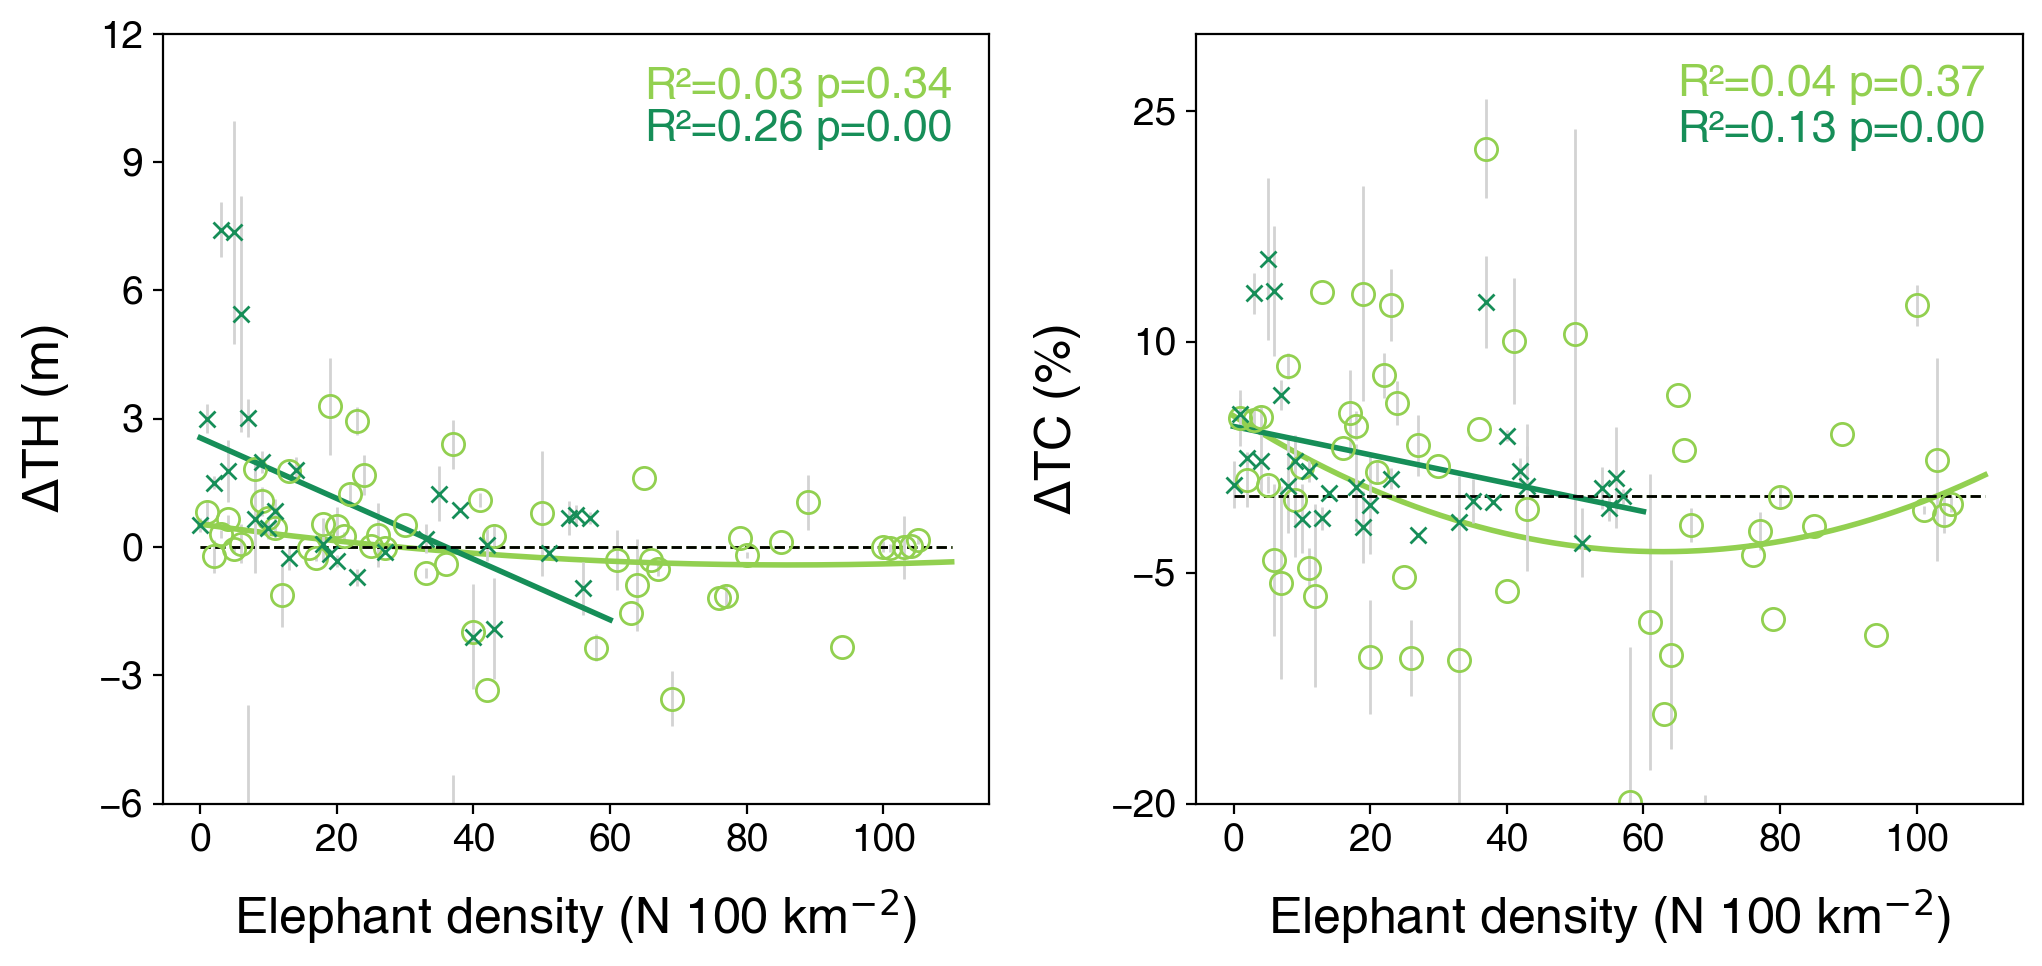

In [96]:
val_LA=[th_val_LA,tc_val_LA]
std_LA=[std_th_LA,std_tc_LA]

val_LC=[th_val_LC,tc_val_LC]
std_LC=[std_th_LC,std_tc_LC]

from sklearn.metrics import r2_score
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,5)) ##width, height default(8,6)
fig.subplots_adjust(wspace=0.25,hspace=0, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  # pass in the font dict as kwargs

x1=np.linspace(0,110,1000)
x2=np.linspace(0,60,1000)
zero=np.zeros((1000))

cl1 = np.array([(146,208,80)])
cl=cl1/255

cl2 = np.array([(22,142,88)])
cl2=cl2/255

for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    #---------------LA---------------
    ax.errorbar(dens_uni_LA,val_LA[i],yerr=[std_LA[i],std_LA[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=8,mfc='none',mec=cl,capsize=2)
    if i ==0:
        poly=np.polyfit(dens_uni_LA,val_LA[i],deg=2)#一元二次方程拟合,,w=count
    elif i==1:
        poly=np.polyfit(dens_uni_LA,val_LA[i],deg=2)#一元二次方程拟合,,w=count
    y_value=np.polyval(poly,x1)
    yfit=np.polyval(poly,dens_uni_LA)
    r2=r2_score(val_LA[i],yfit)
    lm = pg.linear_regression(dens_uni_LA,val_LA[i])
    r2=lm['r2'][0]
    p_value=lm['pval'][0]
    plt.plot(x1,y_value,color=cl,linewidth=2)
    plt.plot(x1,zero,color=cl,linestyle='--',linewidth=1)
    #---------------LC---------------
    ax.errorbar(dens_uni_LC,val_LC[i],yerr=[std_LC[i],std_LC[i]],fmt='o',ecolor='lightgray',elinewidth=1,capthick=0,ms=6,mfc='none',mec=cl2,capsize=2,marker='x')
    poly=np.polyfit(dens_uni_LC,val_LC[i],deg=1)#一元二次方程拟合,,w=count
    y_value=np.polyval(poly,x2)
    yfit=np.polyval(poly,dens_uni_LC)
    #slope, intercept, r_value, p_value1, std_err = stats.linregress(dens_uni_LC,val_LC[i])
    lm = pg.linear_regression(dens_uni_LC,val_LC[i])
    r2_a=lm['r2'][0]
    p_value1=lm['pval'][0]
    plt.plot(x2,y_value,color=cl2,linewidth=2)
    #plt.plot(x2,zero,color='black',linestyle='--',linewidth=1)
    ax.hlines(0,0,110,lw=1,ls='--',color='black')
    plt.xlabel('Elephant density (N 100 km$^{-2}$)',fontsize=18,labelpad=10)
    #ax.set_xlim(0,110)
    #ax.set_xticks(np.arange(0,110.01,20))
    if i==0:
        ax.text(65,10.5, 'R\u00b2={:.2f}'.format(r2),color=(146/255,208/255,80/255))
        ax.text(65,9.5, 'R\u00b2={:.2f}'.format(r2_a),color=(22/255,142/255,88/255))
        ax.text(90,10.5, 'p={:.2f}'.format(p_value),color=(146/255,208/255,80/255))
        ax.text(90,9.5, 'p={:.2f}'.format(p_value1),color=(22/255,142/255,88/255))
        ax.set_ylim(-6,12)
        ax.set_yticks(np.arange(-6,12.01,3))
        ax.set_ylabel(''r'$\Delta$TH'" (m)",fontsize=18,labelpad=10)
    if i==1:
        ax.text(65,26, 'R\u00b2={:.2f}'.format(r2),color=(146/255,208/255,80/255))
        ax.text(65,23, 'R\u00b2={:.2f}'.format(r2_a),color=(22/255,142/255,88/255))
        ax.text(90,26, 'p={:.2f}'.format(p_value),color=(146/255,208/255,80/255))
        ax.text(90,23, 'p={:.2f}'.format(p_value1),color=(22/255,142/255,88/255))
        ax.set_ylim(-20,30)
        ax.set_yticks(np.arange(-20,30.01,15))
        ax.set_ylabel(''r'$\Delta$TC'" (%)",fontsize=18,labelpad=10)
        
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(labelsize=14)